# Using SCProcessing Package for ImmuneCSF train test split.
- Making a train split column
- Cleaning metadata
- Adding numeric cluster labels

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scanpy as sc
import seaborn as sns
from SCProcessing import TrainSplit
from sklearn.preprocessing import OneHotEncoder, LabelEncoder

In [ ]:
adata = sc.read_h5ad('~/GSE163005_IMMUNE_CSF/GSE_ImmuneCSF_qc_hvg_anno_5k_raw.h5ad')

In [3]:
adata

AnnData object with n_obs × n_vars = 75540 × 5000
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'barcodes', 'celltypes', 'condition', 'patient', 'percent_mito', 'RNA_snn_res.0.2', 'RNA_snn_res.0.4', 'RNA_snn_res.0.6', 'RNA_snn_res.0.8', 'RNA_snn_res.1', 'seurat_clusters', 'general_celltypes', 'kmeans_11'
    var: 'vst.mean', 'vst.variance', 'vst.variance.expected', 'vst.variance.standardized', 'vst.variable'
    uns: 'neighbors'
    obsm: 'X_harmony', 'X_pca', 'X_umap'
    varm: 'HARMONY', 'PCs'
    obsp: 'distances'

In [5]:
adata.obs['celltypes'] = adata.obs['general_celltypes']
adata.obs['RNA_snn_res.0.2'] = pd.Categorical(adata.obs['RNA_snn_res.0.2'])
adata.obs['RNA_snn_res.0.4'] = pd.Categorical(adata.obs['RNA_snn_res.0.4'])

There is a lot of extra metadata that is redundant so I will remove.

In [6]:
adata.obs = adata.obs.drop(columns=['RNA_snn_res.0.6', 'RNA_snn_res.0.8', 'RNA_snn_res.1', 'seurat_clusters'])

#### Lets quickly visualize what the data looks like

... storing 'celltypes' as categorical
... storing 'condition' as categorical
... storing 'patient' as categorical
... storing 'general_celltypes' as categorical


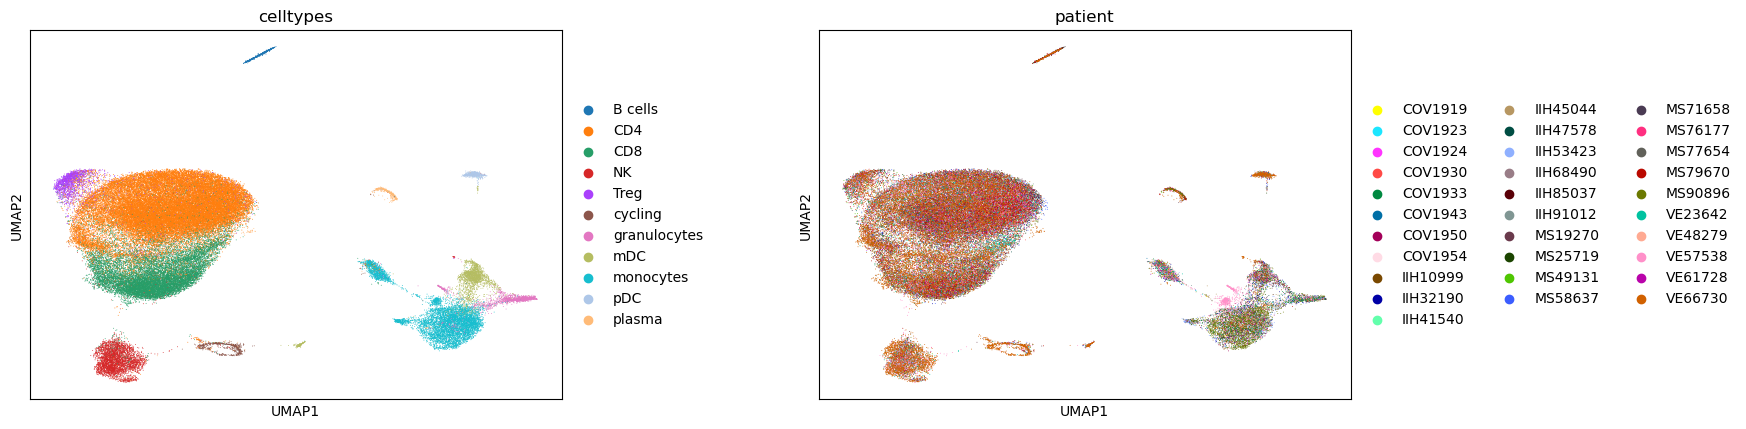

In [7]:
sc.pl.umap(adata, color=['celltypes', 'patient'], wspace=0.35)

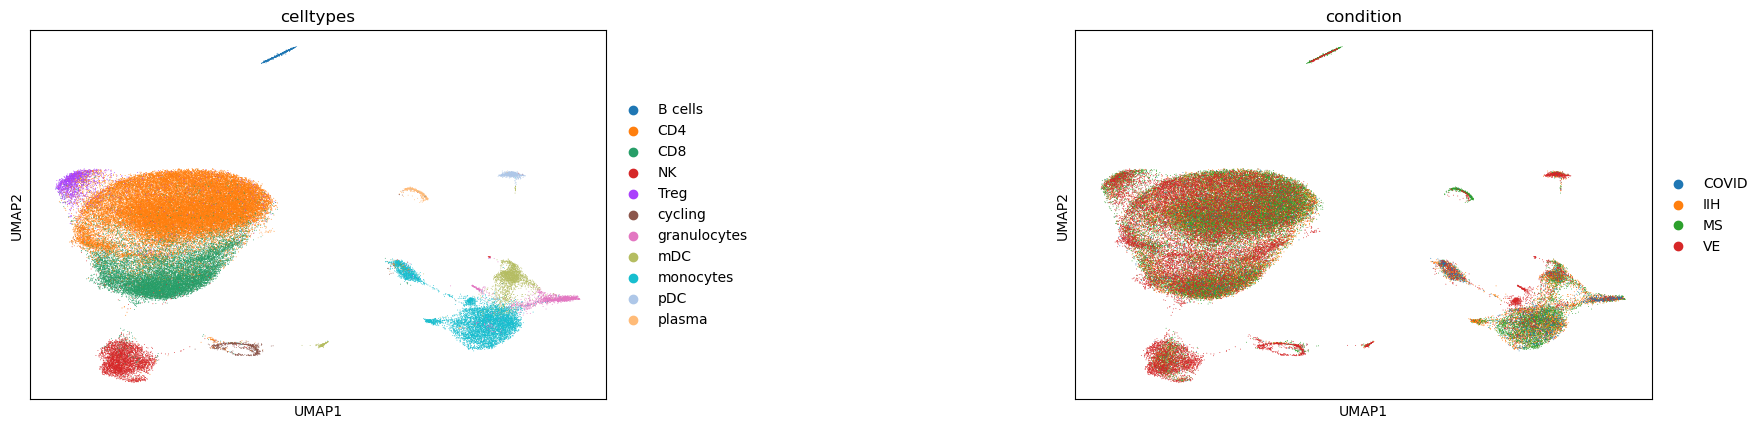

In [8]:
sc.pl.umap(adata, color=['celltypes', 'condition'], wspace=0.65)

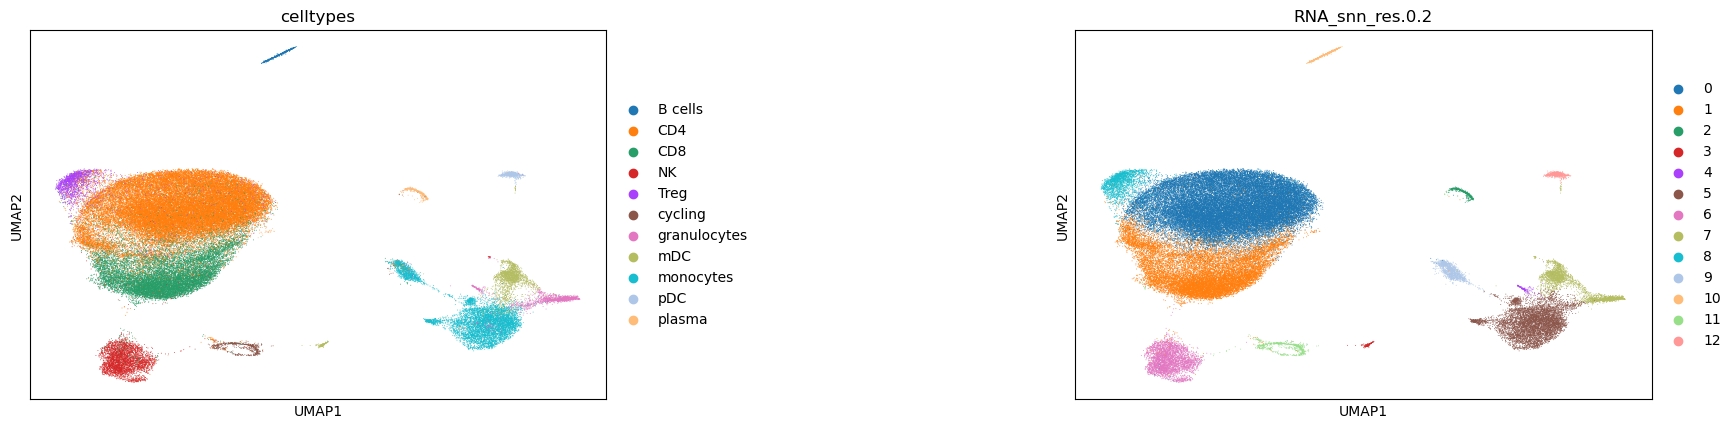

In [9]:
sc.pl.umap(adata, color=['celltypes', 'RNA_snn_res.0.2'], wspace=0.65)

#### Prep for N-ACT

- Create encoded version of 'celltypes' column
- Generate a train/test split of the data (80/20)

In [10]:
encoder_celltype = LabelEncoder()
encoder_celltype.fit(adata.obs['celltypes'])

LabelEncoder()

In [11]:
adata.obs['encoded_celltypes']= encoder_celltype.transform(adata.obs['celltypes']).tolist()

In [12]:
adata.raw.X

<75540x5000 sparse matrix of type '<class 'numpy.float64'>'
	with 19618570 stored elements in Compressed Sparse Row format>

Create a column labeled 'cluster' for SCProcessing to create a balanced split

In [13]:
adata.obs['cluster'] = adata.obs['encoded_celltypes'].tolist()

In [14]:
adata.obs['cluster'].value_counts()

1     40185
2     15226
8      7526
3      4000
7      2199
4      2145
6      1412
0      1006
9       665
5       628
10      548
Name: cluster, dtype: int64

In [15]:
print(f'80%: {75500 * 0.8}')
print(f'20%: {75500 * 0.2}')

80%: 60400.0
20%: 15100.0


In [20]:
obj = TrainSplit(adata, 60400, 0, 15100, balancedSplit=True)

In [21]:
obj.Split()

==> Splitting:
GOT HERE
==> Saving cluster ratios:
    -> Number of clusters: 11
-><- Saved cluster ratios to object attributes
-><- Splitting done
Splitting took 0.11019301414489746 seconds


In [22]:
adata.obs['split'].value_counts()

train    60440
test     15100
valid        0
Name: split, dtype: int64

In [23]:
adata[adata.obs['split'] == 'test'].obs['cluster'].value_counts()

1     7900
2     3116
8     1509
3      813
7      444
4      423
6      280
0      196
5      148
9      145
10     126
Name: cluster, dtype: int64

#### Check dtype for sparse matrix (prefer float 32)

In [24]:
adata.X

<75540x5000 sparse matrix of type '<class 'numpy.float64'>'
	with 19618570 stored elements in Compressed Sparse Row format>

In [25]:
adata.raw.X

<75540x5000 sparse matrix of type '<class 'numpy.float64'>'
	with 19618570 stored elements in Compressed Sparse Row format>

Convert to float 32

In [26]:
from scipy.sparse import csr_matrix
adata.X = csr_matrix(adata.X, dtype=np.float32)

In [27]:
raw_mat = adata.raw.X

In [28]:
raw_mat = raw_mat.todense()

In [29]:
raw_mat = np.array(raw_mat, dtype=np.float32)

In [30]:
raw_mat

array([[0., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [1., 0., 0., ..., 0., 0., 0.],
       [3., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [31]:
import anndata
adata2 = anndata.AnnData(raw_mat)
adata2.X = csr_matrix(adata2.X, dtype=np.float32)

In [32]:
adata.raw = adata2

In [33]:
adata.raw.X.todense()

matrix([[0., 0., 0., ..., 0., 0., 0.],
        [1., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [1., 0., 0., ..., 0., 0., 0.],
        [3., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [34]:
adata.write_h5ad('~/GSE163005_IMMUNE_CSF/GSE_ImmuneCSF_qc_hvg_anno_5k_raw_train_split.h5ad')